In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Load the FER-2013 dataset
df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')

# Display the first few rows of the dataframe
df.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


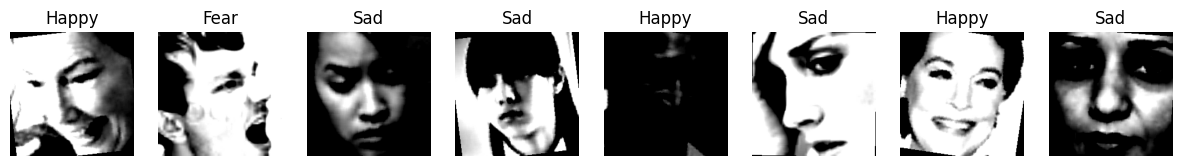

In [2]:
# Data Preprocessing
import matplotlib.pyplot as plt

# Define the custom dataset class
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, 1], dtype=int, sep=' ').reshape(48, 48).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')  # Convert grayscale to RGB
        label = int(self.dataframe.iloc[idx, 0])

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

# Split the dataset
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']

# Create datasets
train_dataset = FER2013Dataset(train_df, transform=train_transform)
val_dataset = FER2013Dataset(val_df, transform=val_test_transform)
test_dataset = FER2013Dataset(test_df, transform=val_test_transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to display images
def show_images(images, labels, classes, num_images=8):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy().squeeze(), cmap='gray')
        plt.title(classes[labels[i].item()])
        plt.axis('off')
    plt.show()

# Classes in the FER-2013 dataset
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
show_images(images, labels, classes)

In [3]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [4]:
# Model Selection and Architecture
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet

# Define the number of classes in the FER-2013 dataset
num_classes = 7

# Load the pre-trained EfficientNet-B0 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the final fully connected layer to match the number of classes
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training parameters
num_epochs = 20
patience = 5  # Early stopping patience
best_val_loss = np.inf
epochs_no_improve = 0

# Define training and validation functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    return train_loss, train_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    return val_loss, val_accuracy

# Training loop with early stopping
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print('Early stopping!')
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 221MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch 1/20, Train Loss: 1.1356, Train Accuracy: 57.50%, Val Loss: 1.1145, Val Accuracy: 61.10%
Epoch 2/20, Train Loss: 0.9408, Train Accuracy: 64.61%, Val Loss: 1.0150, Val Accuracy: 62.55%
Epoch 3/20, Train Loss: 0.8574, Train Accuracy: 68.19%, Val Loss: 0.9944, Val Accuracy: 63.83%
Epoch 4/20, Train Loss: 0.7868, Train Accuracy: 70.46%, Val Loss: 1.0067, Val Accuracy: 63.78%
Epoch 5/20, Train Loss: 0.7347, Train Accuracy: 72.61%, Val Loss: 0.9349, Val Accuracy: 66.82%
Epoch 6/20, Train Loss: 0.6708, Train Accuracy: 75.25%, Val Loss: 0.9525, Val Accuracy: 67.01%
Epoch 7/20, Train Loss: 0.6120, Train Accuracy: 77.40%, Val Loss: 1.0830, Val Accuracy: 67.07%
Epoch 8/20, Train Loss: 0.5563, Train Accuracy: 79.60%, Val Loss: 1.0325, Val Accuracy: 67.90%
Epoch 9/20, Train Loss: 0.4971, Train Accuracy: 81.62%, Val Loss: 1.1085, Val Accuracy: 68.32%
Epoch 10/20, Train Loss: 0.4494, Train Accuracy: 83.10%, Val Loss: 1.2499, Val Accuracy: 66.73%
Ear

<All keys matched successfully>

In [5]:

# Hyperparameter Tuning
# Define hyperparameters grid
from sklearn.model_selection import ParameterGrid
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64]
}

# Function to train and validate the model
def train_and_evaluate(params):
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Load the pre-trained EfficientNet-B0 model
    model = EfficientNet.from_pretrained('efficientnet-b0')

    # Modify the final fully connected layer to match the number of classes
    model._fc = nn.Linear(model._fc.in_features, num_classes)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move the model to the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Training parameters
    num_epochs = 20
    best_val_loss = np.inf

    # Define training and validation functions
    def train(model, train_loader, criterion, optimizer, device):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total

        return train_loss, train_accuracy

    def validate(model, val_loader, criterion, device):
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100. * correct / total

        return val_loss, val_accuracy

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss, val_accuracy

# Perform hyperparameter tuning
results = []
param_combinations = list(ParameterGrid(param_grid))

for params in param_combinations:
    print(f"Training with params: {params}")
    val_loss, val_accuracy = train_and_evaluate(params)
    results.append({
        'params': params,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


Training with params: {'batch_size': 32, 'learning_rate': 0.001}
Loaded pretrained weights for efficientnet-b0
Epoch 1/20, Train Loss: 1.1688, Train Accuracy: 55.84%, Val Loss: 1.1682, Val Accuracy: 57.79%
Epoch 2/20, Train Loss: 0.9826, Train Accuracy: 63.24%, Val Loss: 1.0609, Val Accuracy: 60.55%
Epoch 3/20, Train Loss: 0.9084, Train Accuracy: 66.33%, Val Loss: 0.9823, Val Accuracy: 64.53%
Epoch 4/20, Train Loss: 0.8547, Train Accuracy: 68.06%, Val Loss: 1.0435, Val Accuracy: 64.50%
Epoch 5/20, Train Loss: 0.7984, Train Accuracy: 70.33%, Val Loss: 0.9424, Val Accuracy: 65.98%
Epoch 6/20, Train Loss: 0.7515, Train Accuracy: 71.71%, Val Loss: 0.9900, Val Accuracy: 65.70%
Epoch 7/20, Train Loss: 0.7054, Train Accuracy: 73.88%, Val Loss: 0.9443, Val Accuracy: 67.79%
Epoch 8/20, Train Loss: 0.6487, Train Accuracy: 75.85%, Val Loss: 1.0024, Val Accuracy: 67.29%
Epoch 9/20, Train Loss: 0.6053, Train Accuracy: 77.40%, Val Loss: 1.0205, Val Accuracy: 66.43%
Epoch 10/20, Train Loss: 0.5564, T

Validation Accuracy: 0.67
Validation Precision: 0.67
Validation Recall: 0.67
Validation F1-Score: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.66      0.59       467
           1       0.79      0.41      0.54        56
           2       0.59      0.36      0.45       496
           3       0.84      0.88      0.86       895
           4       0.57      0.58      0.57       653
           5       0.80      0.80      0.80       415
           6       0.59      0.64      0.61       607

    accuracy                           0.67      3589
   macro avg       0.67      0.62      0.63      3589
weighted avg       0.67      0.67      0.66      3589



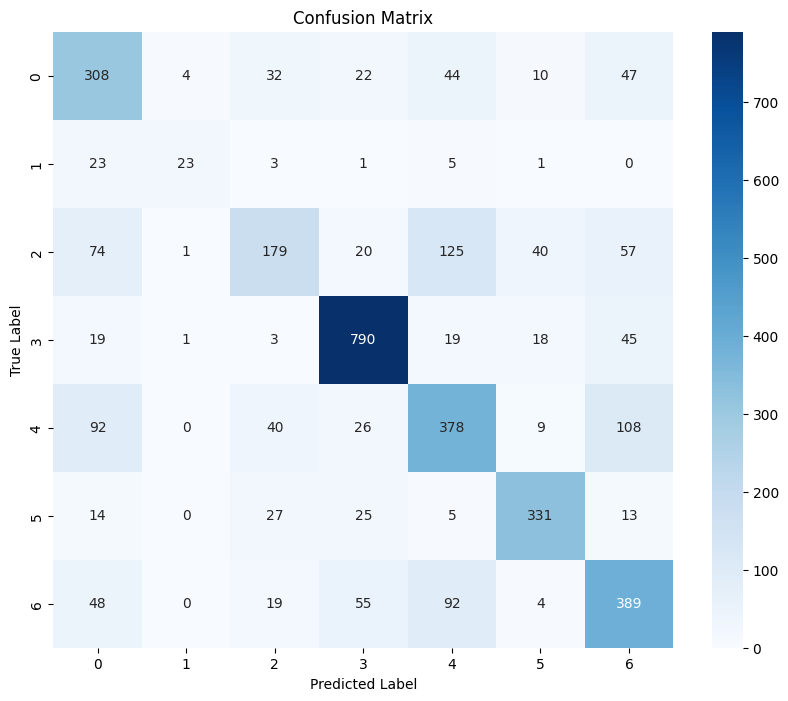

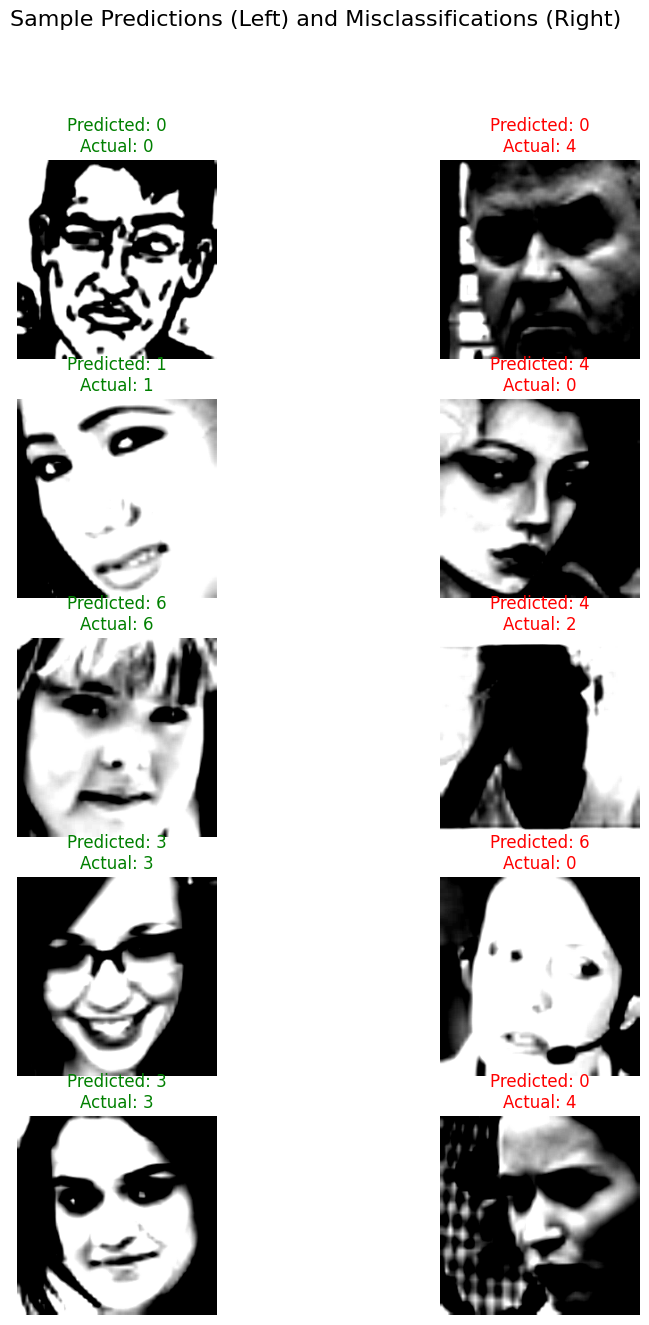

In [6]:
# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the model on a given data loader
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Evaluate the model on the validation dataset
val_labels, val_preds = evaluate_model(model, val_loader, device)

# Calculate evaluation metrics
val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')
val_f1 = f1_score(val_labels, val_preds, average='weighted')

print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Validation Precision: {val_precision:.2f}')
print(f'Validation Recall: {val_recall:.2f}')
print(f'Validation F1-Score: {val_f1:.2f}')

# Print classification report
print('\nClassification Report:')
print(classification_report(val_labels, val_preds, target_names=[str(i) for i in range(num_classes)]))

# Plot confusion matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for validation dataset
plot_confusion_matrix(val_labels, val_preds, classes=[str(i) for i in range(num_classes)])

# Function to plot sample predictions and misclassifications
def plot_predictions_and_misclassifications(images, labels, preds, classes, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, n_samples * 3))

    correct_preds = np.where(np.array(labels) == np.array(preds))[0]
    incorrect_preds = np.where(np.array(labels) != np.array(preds))[0]

    for i in range(n_samples):
        if i < len(correct_preds):
            idx = correct_preds[i]
            ax = axes[i, 0]
            ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
            ax.set_title(f'Predicted: {classes[preds[idx]]}\nActual: {classes[labels[idx]]}', color='green')
            ax.axis('off')

        if i < len(incorrect_preds):
            idx = incorrect_preds[i]
            ax = axes[i, 1]
            ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
            ax.set_title(f'Predicted: {classes[preds[idx]]}\nActual: {classes[labels[idx]]}', color='red')
            ax.axis('off')

    fig.suptitle('Sample Predictions (Left) and Misclassifications (Right)', fontsize=16)
    plt.show()

# Fetch a batch of validation images and labels
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Get predictions for the batch
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = outputs.max(1)

# Plot sample predictions and misclassifications
plot_predictions_and_misclassifications(images, labels.cpu().numpy(), preds.cpu().numpy(), classes=[str(i) for i in range(num_classes)])


Test Accuracy: 0.69
Test Precision: 0.69
Test Recall: 0.69
Test F1-Score: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61       491
           1       0.96      0.40      0.56        55
           2       0.62      0.38      0.47       528
           3       0.85      0.91      0.88       879
           4       0.56      0.59      0.57       594
           5       0.77      0.79      0.78       416
           6       0.64      0.70      0.67       626

    accuracy                           0.69      3589
   macro avg       0.71      0.63      0.65      3589
weighted avg       0.69      0.69      0.68      3589



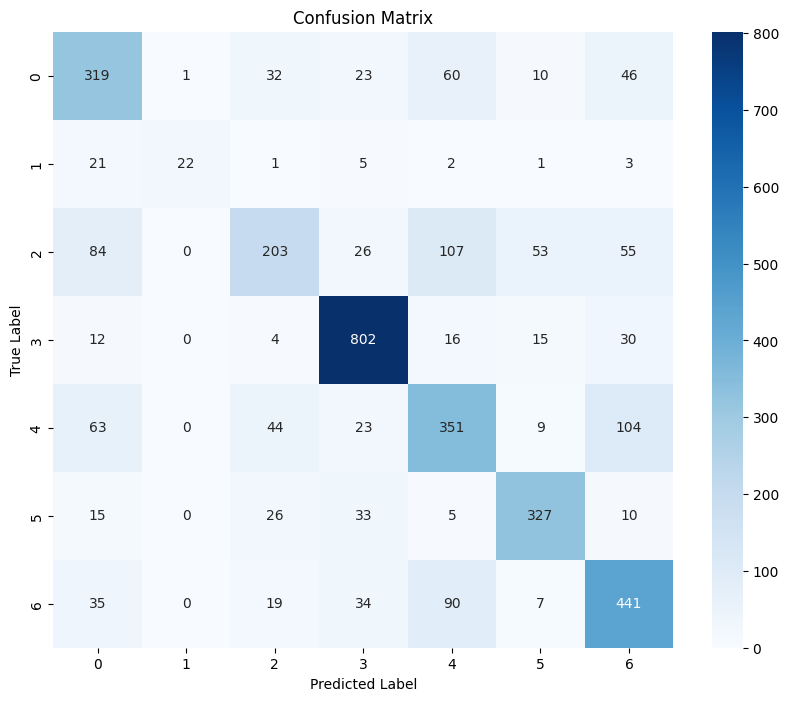

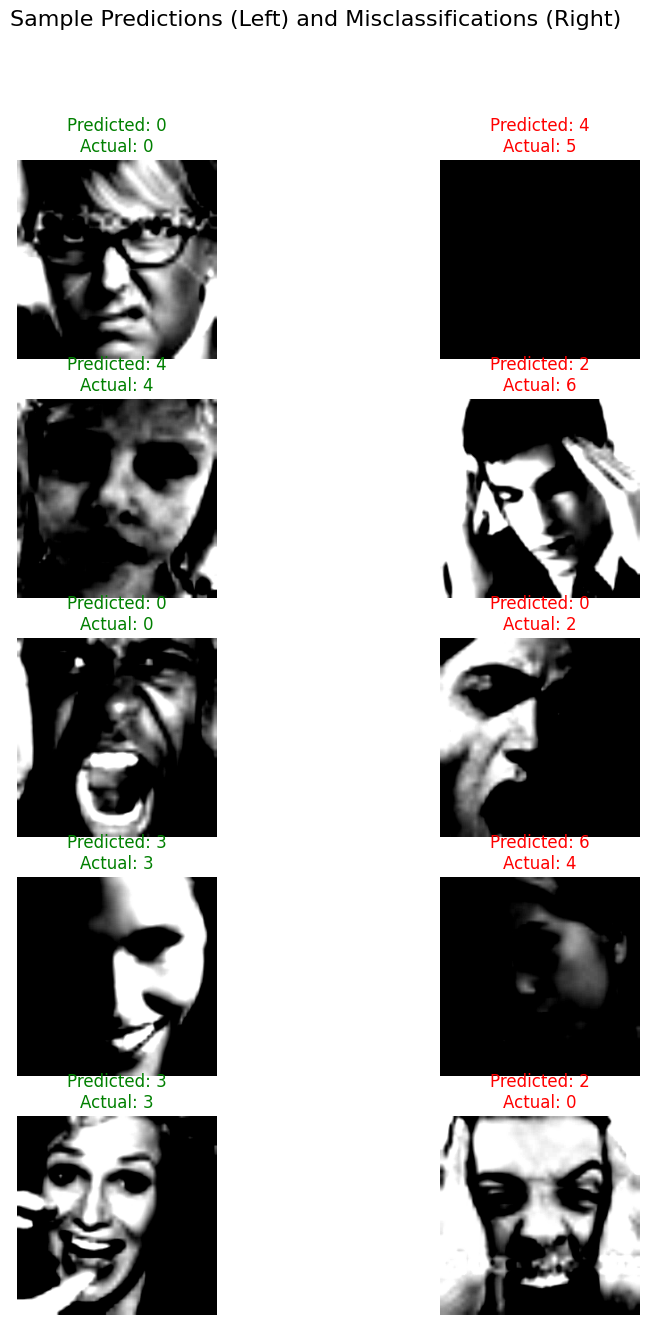

In [11]:
# Final model testing

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test dataset
test_labels, test_preds = evaluate_model(model, test_loader, device)

# Calculate evaluation metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Precision: {test_precision:.2f}')
print(f'Test Recall: {test_recall:.2f}')
print(f'Test F1-Score: {test_f1:.2f}')

# Print classification report
print('\nClassification Report:')
print(classification_report(test_labels, test_preds, target_names=[str(i) for i in range(num_classes)]))

# Plot confusion matrix
plot_confusion_matrix(test_labels, test_preds, classes=[str(i) for i in range(num_classes)])

# Function to plot sample predictions and misclassifications
def plot_predictions_and_misclassifications(images, labels, preds, classes, n_samples=5):
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, n_samples * 3))

    correct_preds = np.where(np.array(labels) == np.array(preds))[0]
    incorrect_preds = np.where(np.array(labels) != np.array(preds))[0]

    for i in range(n_samples):
        if i < len(correct_preds):
            idx = correct_preds[i]
            ax = axes[i, 0]
            ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
            ax.set_title(f'Predicted: {classes[preds[idx]]}\nActual: {classes[labels[idx]]}', color='green')
            ax.axis('off')

        if i < len(incorrect_preds):
            idx = incorrect_preds[i]
            ax = axes[i, 1]
            ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
            ax.set_title(f'Predicted: {classes[preds[idx]]}\nActual: {classes[labels[idx]]}', color='red')
            ax.axis('off')

    fig.suptitle('Sample Predictions (Left) and Misclassifications (Right)', fontsize=16)
    plt.show()

# Fetch a batch of test images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get predictions for the batch
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = outputs.max(1)

# Plot sample predictions and misclassifications
plot_predictions_and_misclassifications(images, labels.cpu().numpy(), preds.cpu().numpy(), classes=[str(i) for i in range(num_classes)])
